# PVC IMPORT model training and testing : prophet + xgboost

## importing dependencies

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from prophet import Prophet
from xgboost import XGBRegressor

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

c:\Users\Dhyey2.Patel\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## Function declaration
Following functions are declared in this section
- function for preprocessing
- function for spliting data into train and testing set
- function for prophet model
- function for XGBoost model 

### Data Preprocessing

In [6]:
def preprocess(dset):

    # selecting only required column
    dset = dset[['ds', 'unitp', 'y']]

    # handling missing values with mean fill method
    dset_mean = dset['unitp'].mean()
    dset['unitp'].fillna(dset_mean, inplace=True)

    dset['cost'] = dset['unitp']*dset['y']

    # formatting date column as per datetime format
    dset['ds'] = pd.to_datetime(dset['ds'], format='mixed')
    dset.sort_values(by='ds', inplace=True)

    # resampling dataset to weekwise frequency
    # resampled_dataset = dset.groupby(pd.Grouper(key='ds', freq='W')).sum().reset_index()
    resampled_dataset = (dset.groupby(pd.Grouper(key='ds', freq='7D', label='left', closed='left')).sum().reset_index())

    # creating lag features
    resampled_dataset['lag_1'] = resampled_dataset['y'].shift(1)
    resampled_dataset.dropna(inplace=True)
    
    return resampled_dataset

### Training and Testing Data Split
- this function takes the dataset to be predicted
- splits the dataset into training and testing dataset
- split is done in 70:30 ratio
- and returns the training, testing and dataset that can be fitted into the model

In [ ]:
def train_test_split(df):
    split = int(df['ds'].count()*0.8)
    
    train = df.iloc[:split+1]
    test = df.iloc[split:]
    
    return train, test

### Prophet: forecasting and plotting
- this function intialises a prophet model
- adds the exogenous variables
- fits the model with training data
- forecast the desired period
- visualises the training and forecasting

this funcation will also display evaluation matrix comparing performance of the model<br>
following are the paramteres used for evaluation
1. Mean Absolute Error
2. Mean Absolute Percentage Error
3. Mean Square Error
4. Root Mean Square Error

In [8]:
def prophet(dset, name):

    # splitting into train,test and model fitting dataset
    train, test = train_test_split(dset)
    train = train[['ds', 'cost', 'y']]
    test = test[['ds', 'cost', 'y']]
    mtest = test[['ds', 'cost']]

    # train-test forecasting
    model = Prophet(interval_width=0.9)
    model.add_regressor('cost', standardize=False)
    fitted_model = model.fit(train)
    forecast = fitted_model.predict(mtest)

    # evaluating
    actual = test['y']
    forecast_total = forecast['yhat']

    # Mean Squared Error (MSE)
    mse = mean_squared_error(actual,forecast_total)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(actual,forecast_total)

    # Mean Absolute Percentage Error (MAPE)
    mape = mean_absolute_percentage_error(actual,forecast_total) * 100  # convert to %

    # plotting
    plt.figure(figsize=(14,5))
    plt.plot(train['ds'], train['y'], color='orange', label='training data', lw=1)
    plt.plot(test['ds'], test['y'], color='blue', label='actual data', lw=1)
    plt.plot(test['ds'], forecast['yhat'], color='green', label='testing forecast with yhat', lw=1)
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='lightblue', alpha=0.4, label='confidence interval')
    plt.title(f'{name} Import forecast with Prophet (WO hyperparameters).')
    plt.legend(loc='best')
    plt.xlabel('Date')
    plt.ylabel('import quantity')
    plt.tight_layout()
    plt.show()
    
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f'Accuracy: {100-mape:.2f}%  (Approx.)')



#### Prophet model hyperparameters tunning


In [ ]:
# Suppress Prophet logs and warnings
from tqdm import tqdm
import logging
warnings.filterwarnings("ignore")
logger = logging.getLogger('prophet')
logger.setLevel(logging.CRITICAL)
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)

def tunner_prophet(dset,list):

    train, test = train_test_split(dset)
    train = train[['ds', 'cost', 'y']]
    test = test[['ds', 'cost', 'y']]
    mtest = test[['ds', 'cost']]

    train = train[['ds', 'cost', 'y']]
    test = test[['ds', 'cost', 'y']]
    mtest = test[['ds', 'cost']] 
   
    model = Prophet(interval_width=0.9, changepoint_prior_scale=list[0], seasonality_prior_scale=list[1], seasonality_mode=list[2], changepoint_range=list[3])
    model.add_regressor('cost', standardize=False)
    fitted_model = model.fit(train)
    forecast = fitted_model.predict(mtest)

    actual = test['y']
    forecast_total = forecast['yhat']

    # Mean Absolute Percentage Error (MAPE)
    mape = mean_absolute_percentage_error(actual,forecast_total) * 100  # convert to %

    return mape

def tuning_prophet(dset):

    dset= dset[['ds', 'cost', 'y']]

    # hyperparameters search space defination
    param1 = [0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 1.0]      # changepoint_prior_scale
    param2 = [0.1, 0.01, 1.0, 5.0, 10.0, 15.0, 20.0, 30.0]       # seasonality_prior_scale
    param3 = ['additive', 'multiplicative']                     # seasonality_mode
    param4 = [0.6, 0.7, 0.8, 0.9, 0.95]                          # changepoint_range

    # calculating total combinations to try
    total_combinations = len(param1) * len(param2) * len(param3) * len(param4)

    # setting best mape as infinity ans best params as none for future update
    best_mape = float('inf')
    best_params = None

    # setting progress bar for total combination 
    count = 1
    # trying each parameters ans finding best with lowest mape score
    with tqdm(total=total_combinations, desc="🔧 Tuning Prophet", ncols=80) as pbar:
        for mode in param3:
            for cp_range in param4:
                for seas_prior in param2:
                    for cp_prior in param1:
                        params = [cp_prior, seas_prior, mode, cp_range]
                        try:
                            mape = tunner_prophet(dset, params)

                            if mape < best_mape:
                                best_params = params
                                best_mape = mape

                            count += 1

                        except Exception:
                            pass

                        pbar.update(1)

    # closing progress bar and returning best params
    # pbar.close()
    print(f"\n✅ Best MAPE: {best_mape:.4f}% with parameters: {best_params}")
    
    return best_params


#### Prophet with hyperparameters

In [24]:
def prophetwp(dset, name, params):

    # splitting into train,test and model fitting dataset
    train, test = train_test_split(dset)
    train = train[['ds', 'cost', 'y']]
    test = test[['ds', 'cost', 'y']]
    mtest = test[['ds', 'cost']]

    # train-test forecasting
    model = Prophet(interval_width=0.9, changepoint_prior_scale=params[0], seasonality_prior_scale=params[1], seasonality_mode=params[2], changepoint_range=params[3])
    model.add_regressor('cost', standardize=False)
    fitted_model = model.fit(train)
    forecast = fitted_model.predict(mtest)

    # evaluating
    actual = test['y']
    forecast_total = forecast['yhat']

    # Mean Squared Error (MSE)
    mse = mean_squared_error(actual,forecast_total)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(actual,forecast_total)

    # Mean Absolute Percentage Error (MAPE)
    mape = mean_absolute_percentage_error(actual,forecast_total) * 100  # convert to %

    # plotting
    plt.figure(figsize=(14,5))
    plt.plot(train['ds'], train['y'], color='orange', label='training data', lw=1)
    plt.plot(test['ds'], test['y'], color='blue', label='actual data', lw=1)
    plt.plot(test['ds'], forecast['yhat'], color='green', label='testing forecast with yhat', lw=1)
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='lightblue', alpha=0.4, label='confidence interval')
    plt.title(f'{name} Import forecast with Prophet (W hyperparameters).')
    plt.legend(loc='best')
    plt.xlabel('Date')
    plt.ylabel('import quantity')
    plt.tight_layout()
    plt.show()
    
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f'Accuracy: {100-mape:.2f}%  (Approx.)')

### XGBoost :forecasting and plotting
- this function intialises a XGBoost model
- process data for model fitting
- fits the model with training data
- forecast the desired period
- visualises the training and forecasting

this funcation will also display evaluation matrix comparing performance of the model<br>
following are the paramteres used for evaluation
1. Mean Absolute Error
2. Mean Absolute Percentage Error
3. Mean Square Error
4. Root Mean Square Error

In [23]:
def xgboost(dset, name):

    # extracting features from datetime columns and droping original datetime column
    dset.loc[:, 'week'] = dset['ds'].dt.isocalendar().week

    train, test = train_test_split(dset)
    x_train, y_train = train[['week', 'cost', 'lag_1']], train['y']
    y_test = test[['week', 'cost', 'lag_1']] 

    # initialising model and fitting it with training and testing dataset
    model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(x_train, y_train)
    forecast = model.predict(y_test)

    # ploting training, testing, and predicted dataset    
    plt.figure(figsize=(14,5))
    plt.plot(train['ds'], train['y'], color='orange', label='training data', lw=1)
    plt.plot(test['ds'], test['y'], color='lightblue', label='testing data', lw=1)
    plt.plot(test['ds'], forecast, color='green', label='test forecast', lw=1)
    plt.legend(loc='best')
    plt.xlabel('date')
    plt.ylabel('import quantity')
    plt.title(f'{name} import forecast with XGBoost (WO Hyperparameters)')
    plt.tight_layout()
    plt.show()
    
    # Mean Squared Error (MSE)
    mse = mean_squared_error(test['y'], forecast)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(test['y'], forecast)

    # Mean Absolute Percentage Error (MAPE)
    mape = mean_absolute_percentage_error(test['y'], forecast) * 100  # convert to %

    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f'Accuracy: {100-mape:.2f}% (Approx.)')


#### XGBoost model hyperparameters tunning

In [12]:
# Suppress Prophet logs and warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")
logger = logging.getLogger('xgboost')
logger.setLevel(logging.CRITICAL)

def tunner_xgboost(dset, params):

    # extracting features from datetime columns and droping original datetime column
    dset.loc[:, 'week'] = dset['ds'].dt.isocalendar().week

    train, test = train_test_split(dset)
    x_train, y_train = train[['week', 'cost', 'lag_1']], train['y']
    y_test = test[['week', 'cost', 'lag_1']] 

    # initialising model and fitting it with training and testing dataset
    model = XGBRegressor(learning_rate = params[0], n_estimators = params[1], max_depth = params[2], objective=params[3], eval_metric=params[4])
    model.fit(x_train, y_train)
    
    # forecasting with testing dataset
    forecast = model.predict(y_test)

    mape = mean_absolute_percentage_error(test['y'], forecast) * 100  # convert to %

    return mape

def tuning_xgboost(dset):

    dset= dset[['ds', 'cost', 'lag_1', 'y']]

    # hyperparameters search space defination
    learning_rate = [0.01, 0.05, 0.1, 0.2, 0.3]
    n_estimators = [100, 200, 300, 500, 700]
    max_depth = [3, 5, 7, 9, 11]
    objective = ['reg:squarederror', 'reg:absoluteerror']
    eval_metric = ['rmse', 'mae']

    # calculating total combinations to try
    total_combinations = len(learning_rate) * len(n_estimators) * len(max_depth) * len(objective) * len(eval_metric) 

    # setting best mape as infinity and best params as none for future update
    best_mape = float('inf')
    best_params = None

    count = 1
    # trying each parameters ans finding best with lowest mape score
    with tqdm(total=total_combinations, desc="🔧 Tuning XGBoost", ncols=80) as pbar:
        for em in eval_metric:
            for obj in objective:
                for md in max_depth:
                    for ne in n_estimators:
                        for lr in learning_rate:
                            params = [lr, ne, md, obj, em]
                            try:
                                mape = tunner_xgboost(dset, params)

                                if mape < best_mape:
                                    best_params = params
                                    best_mape = mape

                            except Exception:
                                pass
                            
                            pbar.update(1)
                        
    # closing progress bar and returning best params
    # pbar.close()
    print(f"\n✅ Best MAPE: {best_mape:.4f}% with parameters: {best_params}")
    
    return best_params


#### XGBoost with Hyperparameters

In [22]:
def xgboostwp(dset, name, params):

    # extracting features from datetime columns and droping original datetime column
    dset.loc[:, 'week'] = dset['ds'].dt.isocalendar().week

    train, test = train_test_split(dset)
    x_train, y_train = train[['week', 'cost', 'lag_1']], train['y']
    y_test = test[['week', 'cost', 'lag_1']] 

    # initialising model and fitting it with training and testing dataset
    model = model = XGBRegressor(learning_rate = params[0], n_estimators = params[1], max_depth = params[2], objective=params[3], eval_metric=params[4])
    model.fit(x_train, y_train)
    forecast = model.predict(y_test)

    # ploting training, testing, and predicted dataset    
    plt.figure(figsize=(14,5))
    plt.plot(train['ds'], train['y'], color='orange', label='training data', lw=1)
    plt.plot(test['ds'], test['y'], color='lightblue', label='testing data', lw=1)
    plt.plot(test['ds'], forecast, color='green', label='test forecast', lw=1)
    plt.legend(loc='best')
    plt.xlabel('date')
    plt.ylabel('import quantity')
    plt.title(f'{name} import forecast with XGBoost (W hyperparameters)')
    plt.tight_layout()
    plt.show()
    
    # Mean Squared Error (MSE)
    mse = mean_squared_error(test['y'], forecast)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(test['y'], forecast)

    # Mean Absolute Percentage Error (MAPE)
    mape = mean_absolute_percentage_error(test['y'], forecast) * 100  # convert to %

    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f'Accuracy: {100-mape:.2f}% (Approx.)')


## Loadind data and preprocessing

In [15]:
df = pd.read_excel('C:/Users/Dhyey2.Patel/Desktop/Dhyey2.Patel/PVC_import_analysis_&_forecasting/data/preprocessed data/PVC-suspension_lead_time.xlsx')
df = df[['ds', 'k', 'unitp', 'y']]

# converting dates to datetime format & sorting
df['ds'] = pd.to_datetime(df['ds'], format='mixed')
df.sort_values(by='ds', inplace=True)

# loading maping dataset
map = pd.read_excel('C:/Users/Dhyey2.Patel/Desktop/Dhyey2.Patel/PVC_import_analysis_&_forecasting/data/preprocessed data/cat_to_num_mapping.xlsx', engine='openpyxl')

# making dictionary of mapping dataset
k_map =  dict(zip(map['k_level'], map['k_code']))

# mapping grades of df to their code from mapping dataset
df['k_code'] = df['k'].map(k_map)

# dropping previous grade column
df.drop('k', axis=1, inplace=True)

print(df.tail())
print('Total import: ',df['y'].sum())

              ds  unitp        y  k_code
97912 2025-06-04  684.0  280.000     2.0
98220 2025-06-04  676.0   12.398     2.0
98221 2025-06-04  676.0   10.198     2.0
97911 2025-06-04  684.0  280.000     2.0
98199 2025-06-04  676.0  117.404     2.0
Total import:  13013663.026074188


## Forecasting individual K-Level

In [20]:
def k_level_forecast(code, name, p_params, x_params):   

    dset = df[(df['k_code'] == code)]
    
    resampled_dset = preprocess(dset)
    train_dset, test_dset = train_test_split(resampled_dset)
    
    if (p_params == None):
        prophet_params = tuning_prophet(train_dset)
    else:
        prophet_params = p_params

    prophetwp(resampled_dset, name, prophet_params)

    if (x_params == None):
        xgboost_params = tuning_xgboost(train_dset)
    else:
        xgboost_params = x_params

    xgboostwp(resampled_dset, name, xgboost_params) 

### Very High K

In [ ]:
prophet_params = None
xgboost_params = None
k_level_forecast(1, 'Very High K', prophet_params, xgboost_params) 

🔧 Tuning Prophet:   0%|                                | 0/640 [00:00<?, ?it/s]16:08:18 - cmdstanpy - INFO - Chain [1] start processing
16:08:19 - cmdstanpy - INFO - Chain [1] done processing
16:08:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
16:08:19 - cmdstanpy - INFO - Chain [1] start processing
16:08:20 - cmdstanpy - INFO - Chain [1] done processing
🔧 Tuning Prophet:   0%|                        | 1/640 [00:01<19:47,  1.86s/it]16:08:20 - cmdstanpy - INFO - Chain [1] start processing
16:08:21 - cmdstanpy - INFO - Chain [1] done processing
16:08:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
16:08:21 - cmdstanpy - INFO - Chain [1] start processing
16:08:22 - cmdstanpy - INFO - Chain [1] done processing
🔧 Tuning Prophet:   0%|                        | 2/640 [00:03<20:44,  1.95s/it]16:08:22 - cmdstanpy - INFO - Chain [1] start processing
16:08:23 - cmdstanpy - INFO - Chain [1] done processing
16:08:

### High K

14:01:47 - cmdstanpy - INFO - Chain [1] start processing
14:01:47 - cmdstanpy - INFO - Chain [1] done processing
14:01:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
14:01:47 - cmdstanpy - INFO - Chain [1] start processing
14:01:49 - cmdstanpy - INFO - Chain [1] done processing


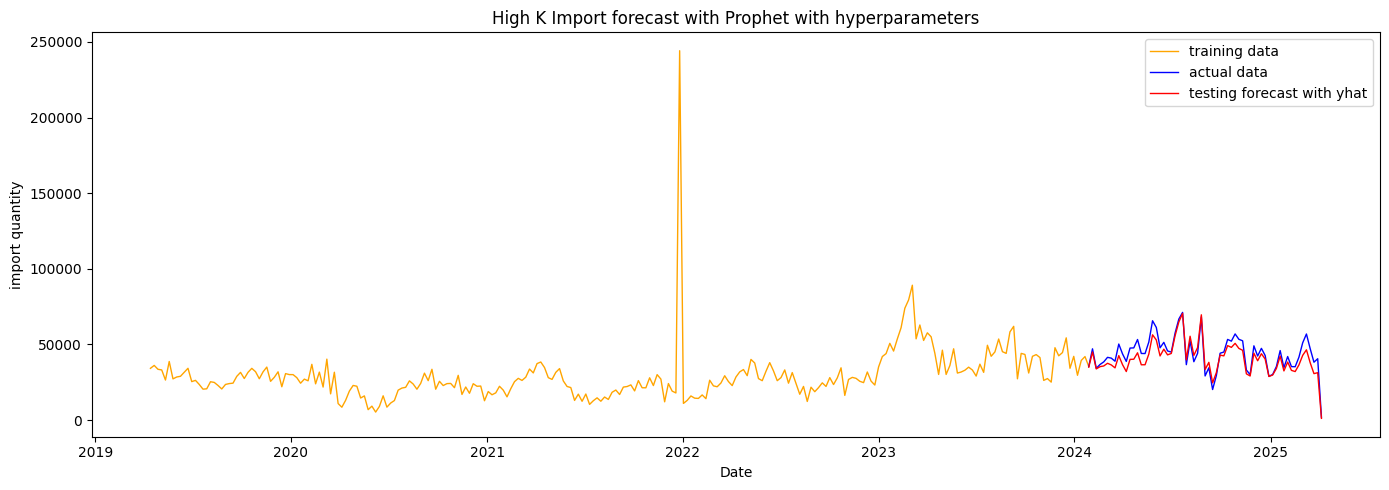

Actual import: 2768989.3740976965 MTs
Predicted import: 2559904.927403641 MTs
MSE: 25583551.97
RMSE: 5058.02
MAE: 4263.98
MAPE: 10.16%
Accuracy: 89.84%  (Approx.)


14:01:50 - cmdstanpy - INFO - Chain [1] start processing
14:01:50 - cmdstanpy - INFO - Chain [1] done processing
14:01:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
14:01:50 - cmdstanpy - INFO - Chain [1] start processing
14:02:01 - cmdstanpy - INFO - Chain [1] done processing


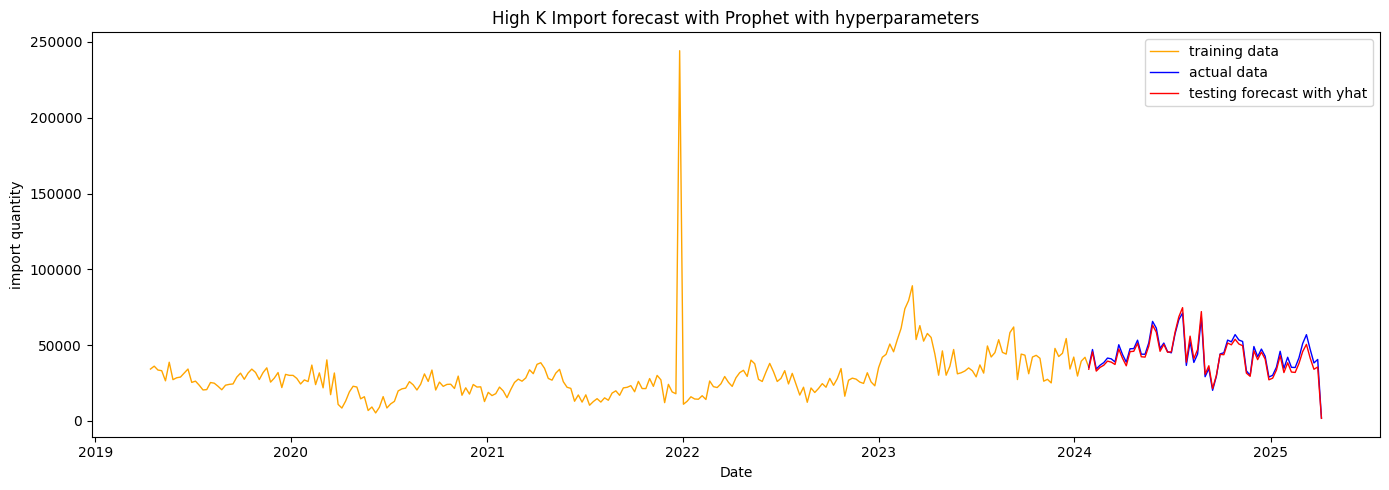

Actual import: 2768989.3740976965 MTs
Predicted import: 2679170.256199068 MTs
MSE: 6797617.13
RMSE: 2607.22
MAE: 2294.20
MAPE: 5.39%
Accuracy: 94.61%  (Approx.)


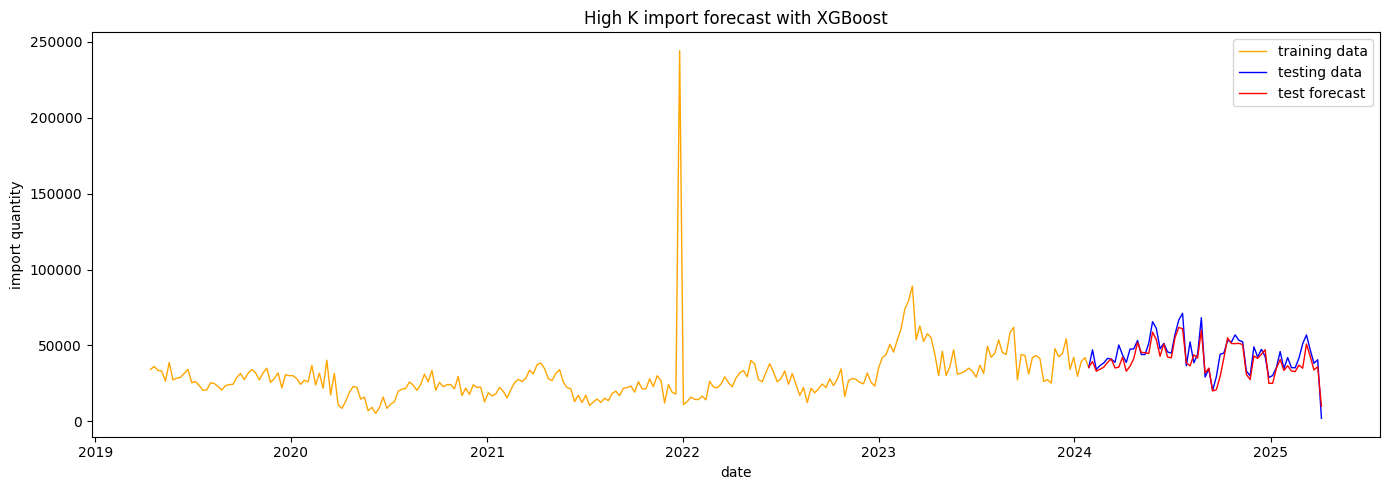

actual import: 2768989.3740976965
predicted import: 2539957.25
MSE: 34576989.95
RMSE: 5880.22
MAE: 4495.95
MAPE: 15.85%
Accuracy: 84.15% (Approx.)


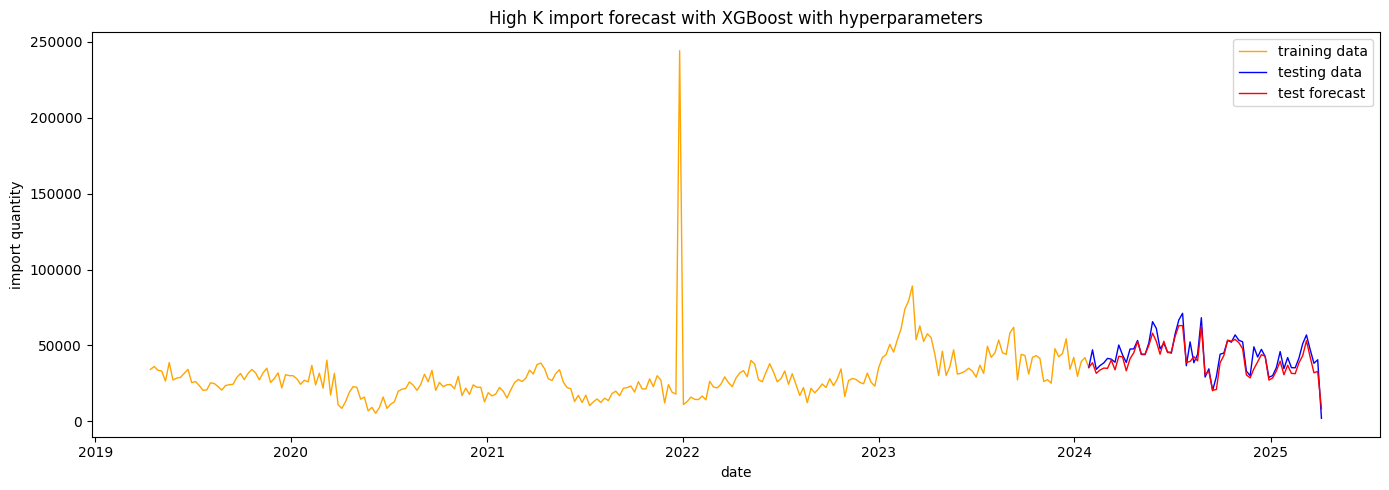

actual import: 2768989.3740976965
predicted import: 2561939.75
MSE: 24179280.71
RMSE: 4917.24
MAE: 3852.86
MAPE: 13.44%
Accuracy: 86.56% (Approx.)


In [ ]:
prophet_params = None
xgboost_params = None
k_level_forecast(2, 'High K', prophet_params, xgboost_params)

### Medium K

14:02:45 - cmdstanpy - INFO - Chain [1] start processing
14:02:45 - cmdstanpy - INFO - Chain [1] done processing
14:02:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
14:02:45 - cmdstanpy - INFO - Chain [1] start processing
14:02:47 - cmdstanpy - INFO - Chain [1] done processing


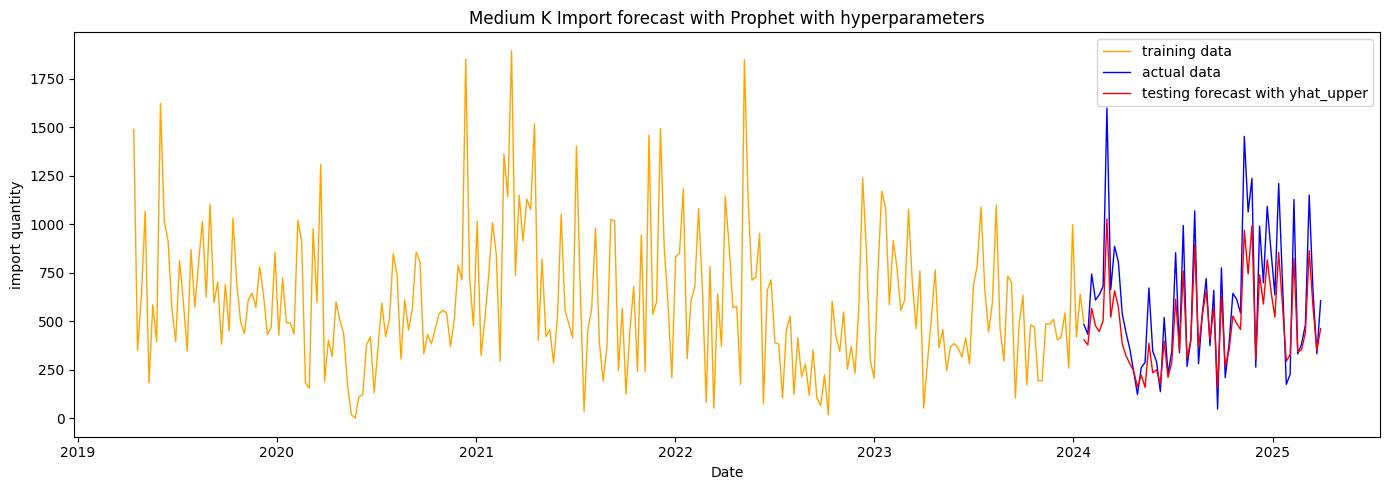

Actual import: 37724.93840004 MTs
Predicted import: 30631.727776773598 MTs
MSE: 31226.46
RMSE: 176.71
MAE: 135.36
MAPE: 24.57%
Accuracy: 75.43%  (Approx.)


14:02:48 - cmdstanpy - INFO - Chain [1] start processing
14:02:49 - cmdstanpy - INFO - Chain [1] done processing
14:02:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
14:02:49 - cmdstanpy - INFO - Chain [1] start processing
14:03:07 - cmdstanpy - INFO - Chain [1] done processing


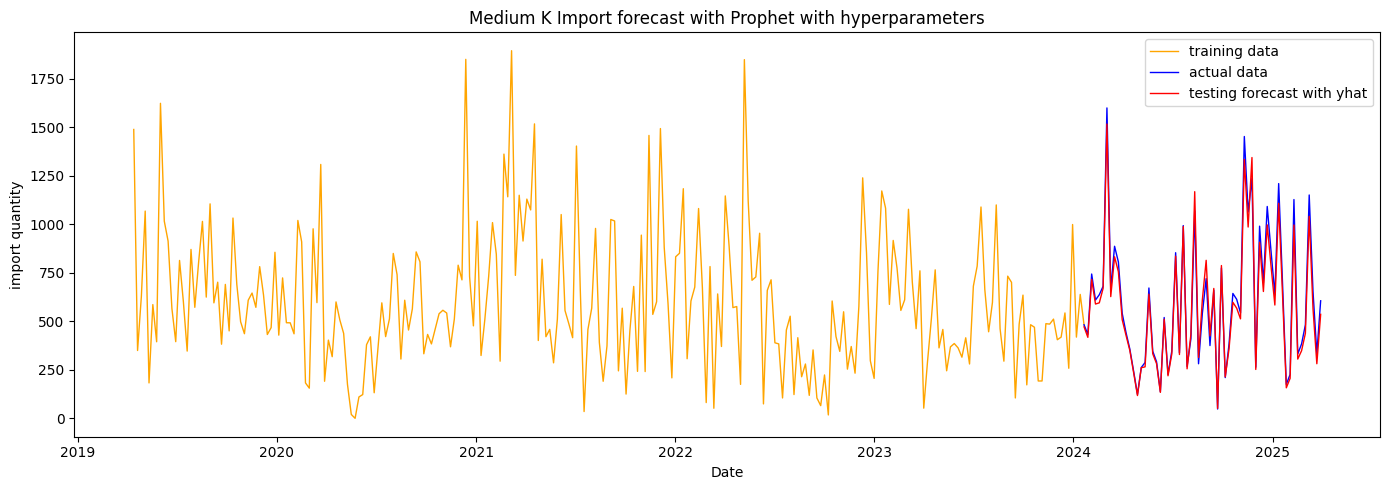

Actual import: 37724.93840004 MTs
Predicted import: 36194.873005941336 MTs
MSE: 2799.52
RMSE: 52.91
MAE: 40.32
MAPE: 6.37%
Accuracy: 93.63%  (Approx.)


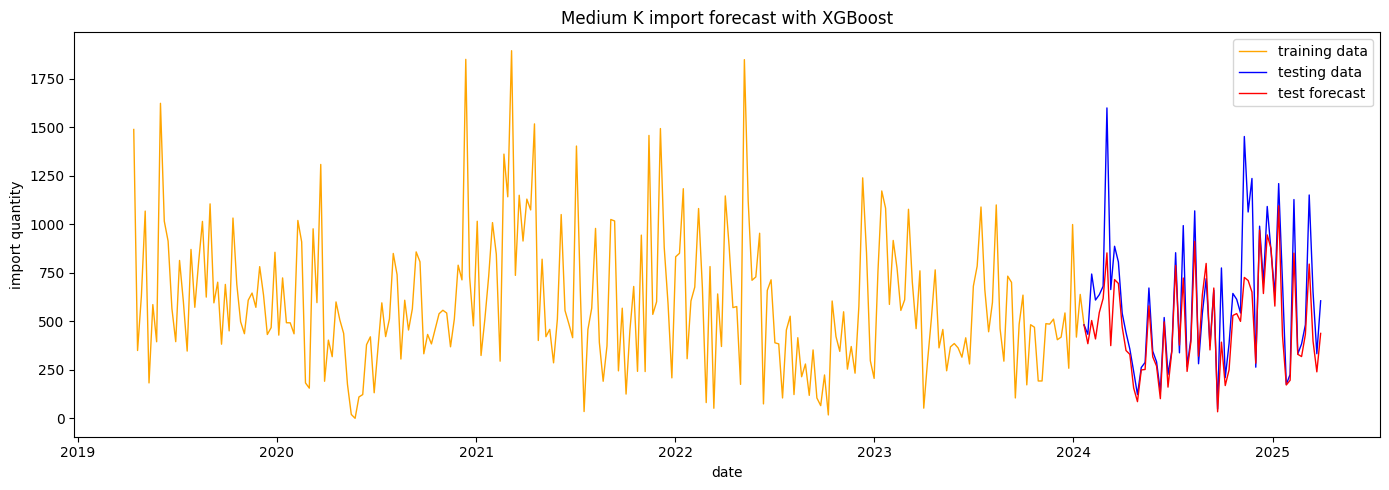

actual import: 37724.93840004
predicted import: 30441.384765625
MSE: 40742.70
RMSE: 201.85
MAE: 125.07
MAPE: 18.22%
Accuracy: 81.78% (Approx.)


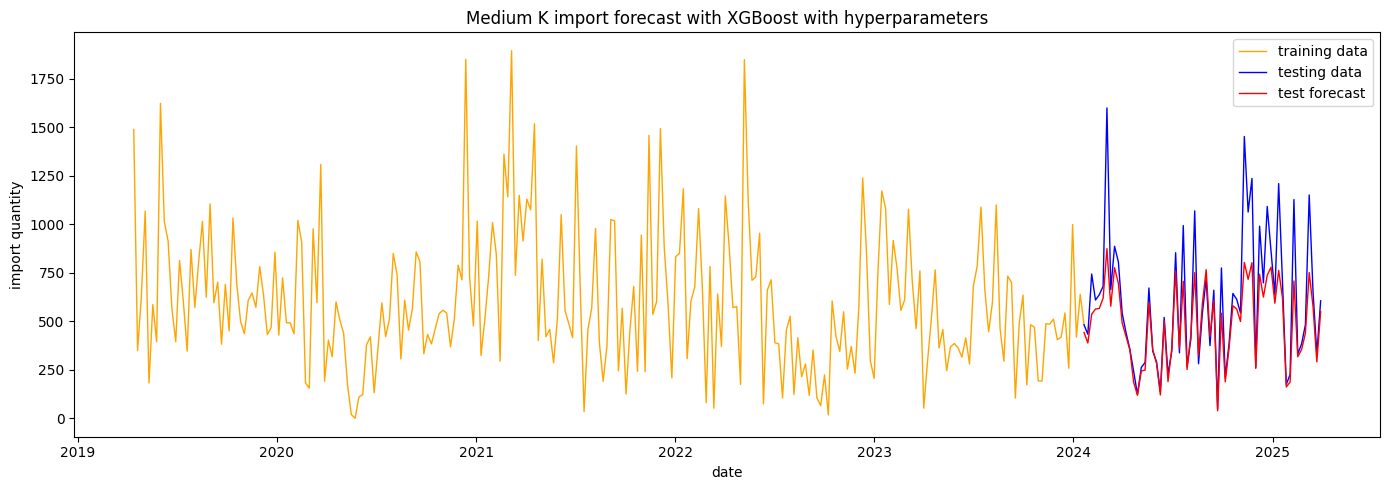

actual import: 37724.93840004
predicted import: 31028.4296875
MSE: 37884.49
RMSE: 194.64
MAE: 114.43
MAPE: 14.33%
Accuracy: 85.67% (Approx.)


In [ ]:
prophet_params = None
xgboost_params = None
k_level_forecast(3, 'Medium K', prophet_params, xgboost_params)

### Low K

14:26:31 - cmdstanpy - INFO - Chain [1] start processing
14:26:31 - cmdstanpy - INFO - Chain [1] done processing
14:26:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
14:26:31 - cmdstanpy - INFO - Chain [1] start processing
14:26:33 - cmdstanpy - INFO - Chain [1] done processing


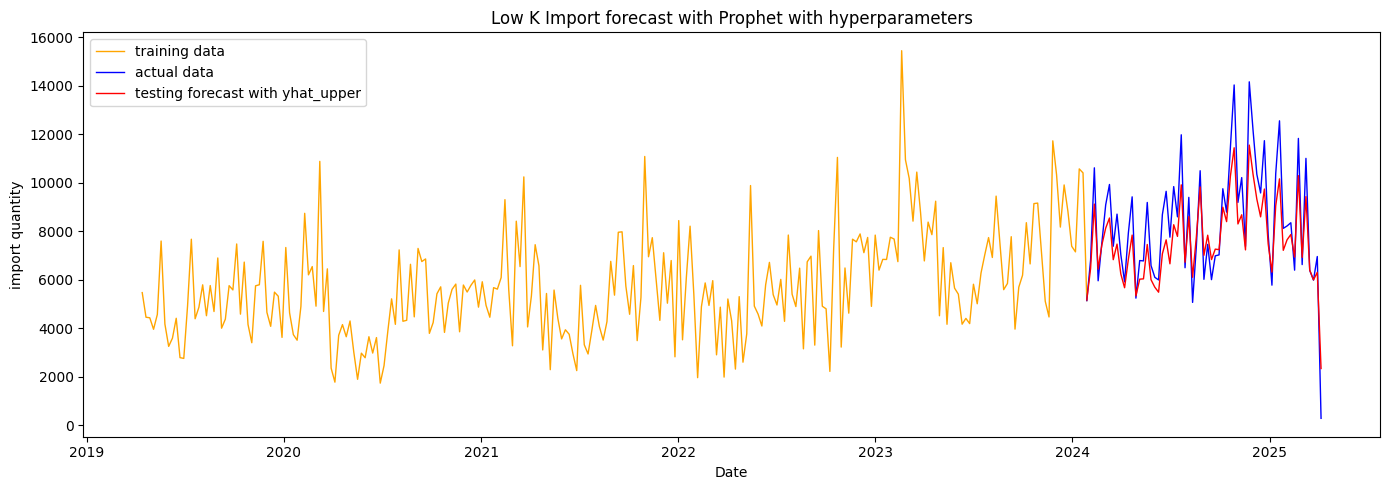

Actual import: 522198.86183455004 MTs
Predicted import: 479719.43624563835 MTs
MSE: 1320223.14
RMSE: 1149.01
MAE: 939.89
MAPE: 21.40%
Accuracy: 78.60%  (Approx.)


14:26:34 - cmdstanpy - INFO - Chain [1] start processing
14:26:34 - cmdstanpy - INFO - Chain [1] done processing
14:26:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
14:26:34 - cmdstanpy - INFO - Chain [1] start processing
14:26:53 - cmdstanpy - INFO - Chain [1] done processing


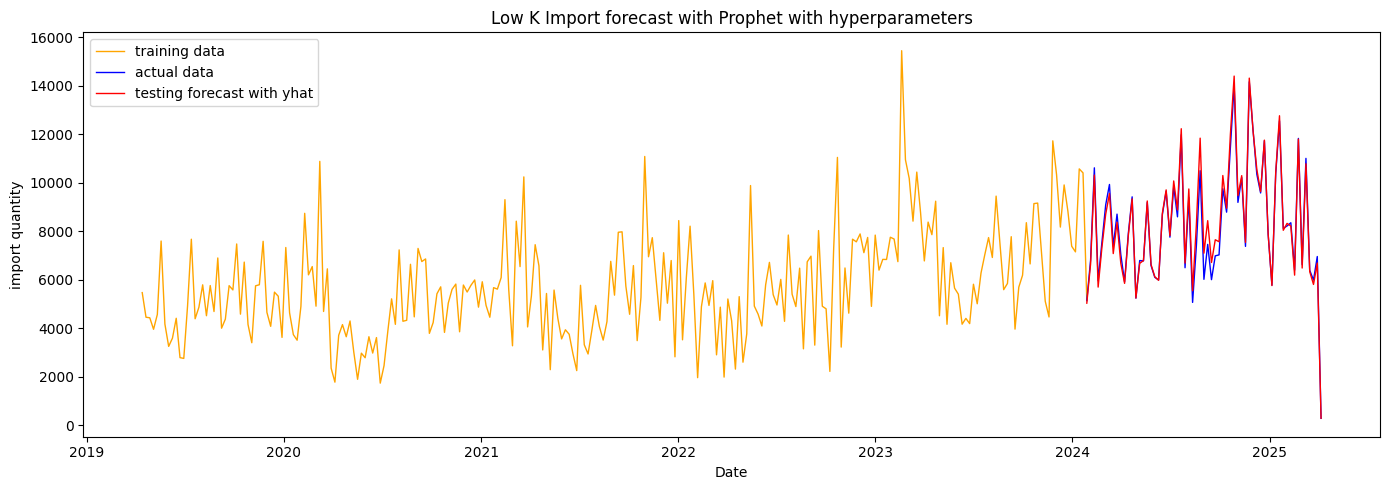

Actual import: 522198.86183455004 MTs
Predicted import: 528947.0382664121 MTs
MSE: 137371.68
RMSE: 370.64
MAE: 250.59
MAPE: 3.20%
Accuracy: 96.80%  (Approx.)


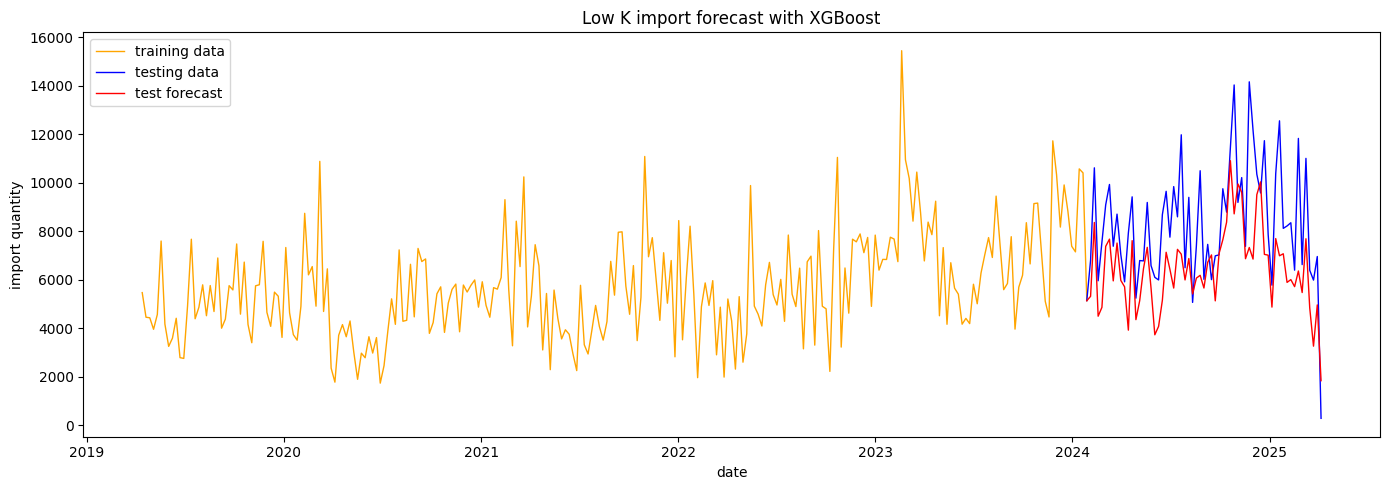

actual import: 522198.86183455004
predicted import: 405780.84375
MSE: 6417396.25
RMSE: 2533.26
MAE: 1980.86
MAPE: 30.30%
Accuracy: 69.70% (Approx.)


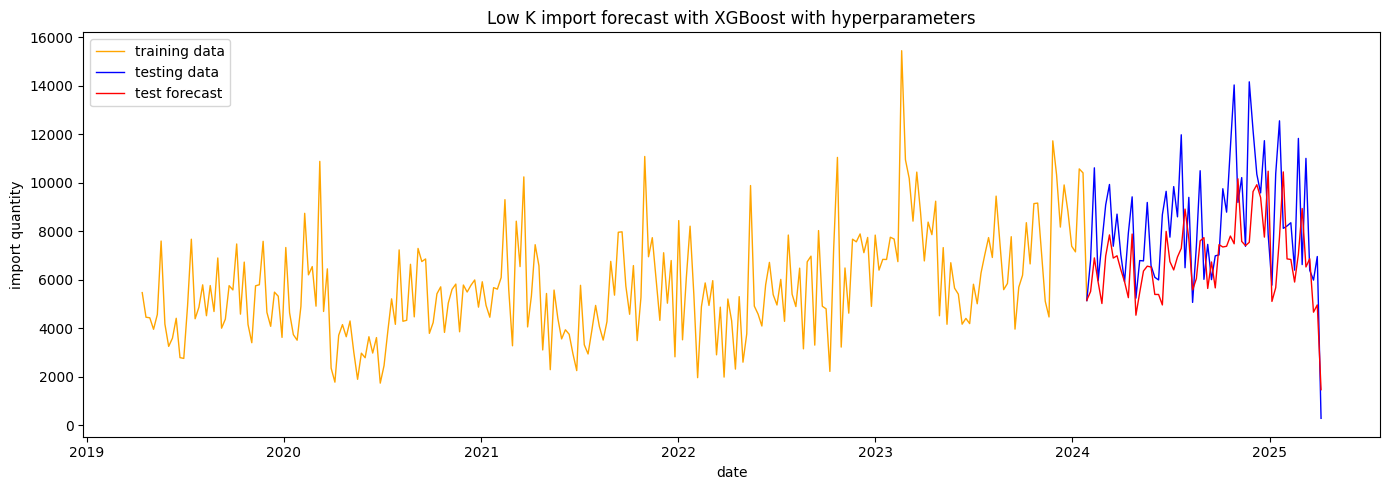

actual import: 522198.86183455004
predicted import: 431041.21875
MSE: 6205168.11
RMSE: 2491.02
MAE: 1945.90
MAPE: 27.41%
Accuracy: 72.59% (Approx.)


In [ ]:
prophet_params = None
xgboost_params = None
k_level_forecast(4, 'Low K', prophet_params, xgboost_params)

## Influencing Factors

| Factor             | Type              | Possible Values / Description                  |
|--------------------|-------------------|------------------------------------------------|
| FOB (free onboard) price (China) | Numerical         | Numerical figures                               |
| Demand             | Qualitative       | low, steady, high, very high                   |
| Freight            | Numerical         | Numerical figures                               |
| Demand in India    | Qualitative       | low, steady, high, very high                   |
| Open market        | Numerical         | Numerical figures                               |
| Benchmark prices   | Numerical         | ICIS and Platts benchmark figures              |
| Co-producers       | Qualitative       | less active, steady, highly active             |
